## <h1 align="center"> The Battle of Neighborhood | London Destinations Chooser <h1/>

Khaldoun Al-Sarraj

16/12/2020

### 1. Introduction

The Romans built the city of Londinium along the River Thames in the year AD 43 The name Londinium (and later 'London') came from the Celtic language of the Ancient Britons. In the year AD 61, the city was attacked and destroyed. Then the Romans rebuilt the city, and London became an important trading hub. After the decline of the Roman Empire, few people remained in London. This was partly because the Anglo-Saxon people of Sub-Roman Britain were primarily agricultural. Once the Romans had gone, trade with Continental Europe dwindled. In the 9th century, more people started living in London again. It became the largest city in England. However, it did not become the capital city of England until the 12th century. 

After the railways were built, London grew very big. Greater London has 33 London Boroughs (Neighborhoods) and a mayor. 
The old City of London is only a square mile in size but has its own Lord Mayor.

Another famous old part of Greater London is Westminster, which was always a different city from the City of London. In Westminster is Westminster Abbey (a cathedral), The Palace of Westminster (the Houses of Parliament, with Big Ben), and 10 Downing Street (where the Prime Minister lives).

A lot has changed over the years and we now take a look at how London city have grown.

London is quite the popular tourist and vacation destinations for people all around the world. It is diverse and multicultural and offer a wide variety of experiences that is widely sought after. We try to group the neighborhoods of London respectively and draw insights to what they look like now.


### 2. Business Problem

The aim is to help tourists choose their destinations depending on the experiences that the neighborhoods have to offer and what they would want to have. This also helps people make decisions if they are thinking about migrating to London or even if they want to relocate neighborhoods within the city. Our findings will help stakeholders make informed decisions and address any concerns they have including the different kinds of cuisines, provision stores and what the city has to offer.

### 3. Data Description

We require geographical location data for London. Postal codes in each city serve as a starting point. Using Postal codes we use can find out the neighborhoods, boroughs, venues and their most popular venue categories. 

#### 3.1. Wikipedia

To derive our solution, we scrape our data from 

https://en.wikipedia.org/wiki/List_of_areas_of_London

This Wikipedia page has information about all the neighborhoods, we limit it London.

London borough: Name of Neighborhood

Post town: Name of borough

Postcode district: Postal codes for London.

This Wikipedia page lacks information about the geographical locations. To solve this problem we use ArcGIS API.

#### 3.2. ArcGIS API

ArcGIS Online enables you to connect people, locations, and data using interactive maps. Work with smart, data-driven styles and intuitive analysis tools that deliver location intelligence. Share your insights with the world or specific groups.

More specifically, we use ArcGIS to get the geo locations of the neighborhoods of London. The following columns are added to our initial dataset which prepares our data.

latitude: Latitude for Neighborhood

longitude: Longitude for Neighborhood

#### 3.3. Foursquare API Data

We will need data about different venues in different neighborhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood. For each neighborhood, we have chosen the radius to be 500 meters.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

Neighborhood: Name of the Neighborhood

Neighborhood Latitude: Latitude of the Neighborhood

Neighborhood Longitude: Longitude of the Neighborhood

Venue: Name of the Venue

Venue Latitude: Latitude of Venue

Venue Longitude: Longitude of Venue

Venue Category: Category of Venue

#### 4. Methodology

#### 4.1 Installing and Importing Python Libraries and Dependencies

```python
!pip install geocoder
!pip install folium
```

Importing Libraries

```python
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")
```

The approach taken here is to explore each of the cities individually, plot the map to show the neighbourhoods being considered and then build our model by clustering all of the similar neighbourhoods together and finally plot the new map with the clustered neighbourhoods. We draw insights and then compare and discuss our findings.

### 4.2 Exploring London

#### Neighbourhoods of London

We begin to start collecting and refining the data needed for the our business solution to work.

#### 4.3 Data Collection

To get the neighbourhoods in london, we start by scraping the list of areas of london wiki page.

```python
url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london_url = requests.get(url_london)
wiki_london_url
```

Response 200 means that we are able to make the connection

```python
wiki_london_data = pd.read_html(wiki_london_url.text)
wiki_london_data
```

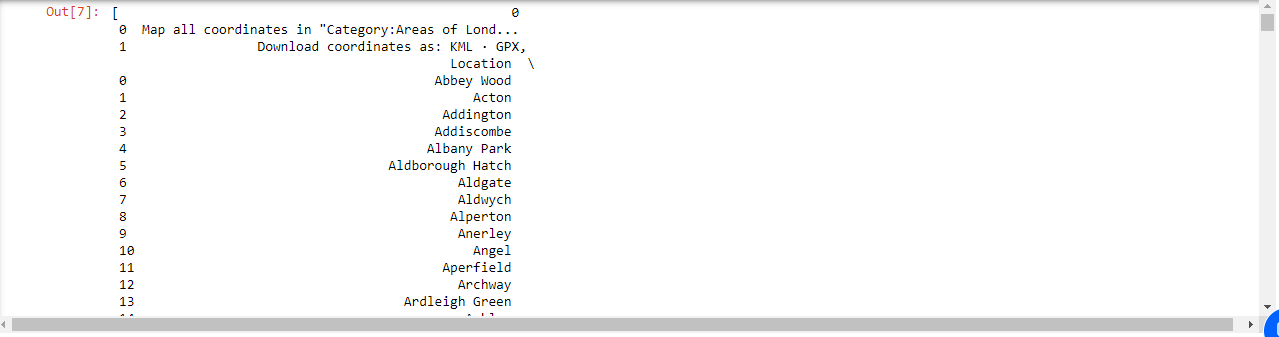

Scraping the webpage gives us all the tables present on the page. We need the 2nd table, so selecting the 2nd table.

```python
wiki_london_data = wiki_london_data[1]
wiki_london_data
```

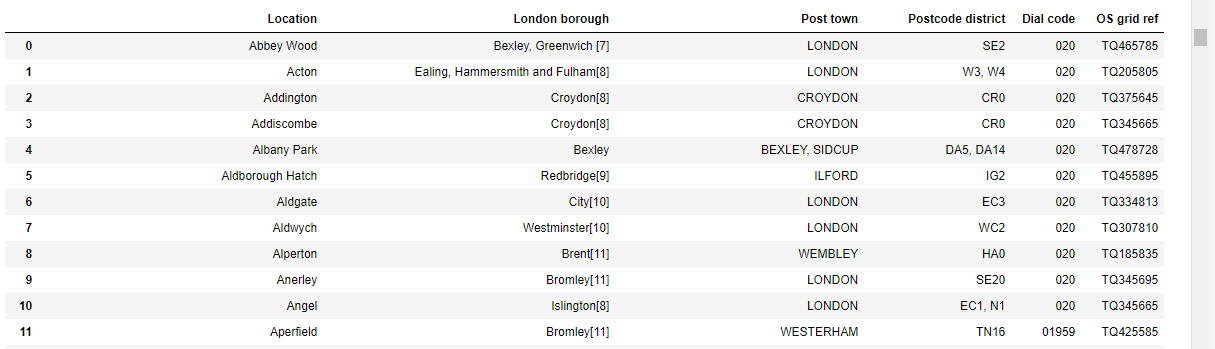

#### 4.4 Data Preprocessing

we remove the spaces in the column titles and then we add _ between words.

```python
wiki_london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
wiki_london_data
```

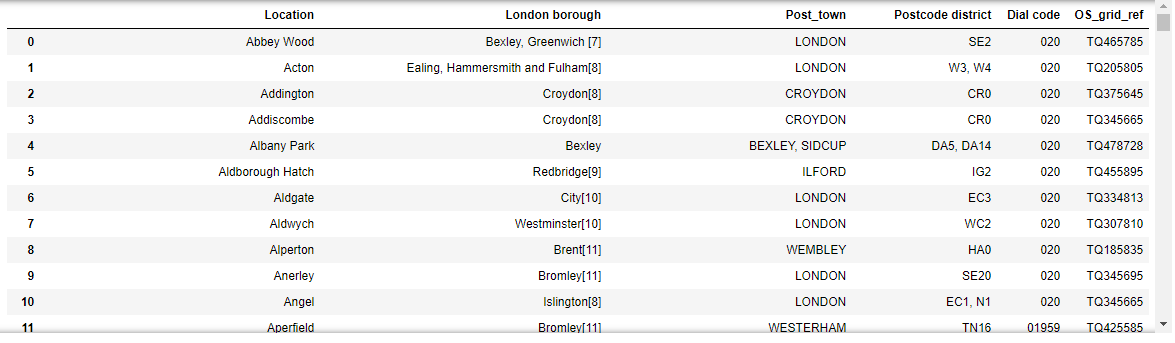

We see that few columns have no '_' between the words despite applying our function meaning that there are special characters

#### 4.5 Feature Selection

We need only the boroughs, Postal codes, Post town for further steps. We can drop the locations, dial codes and OS grid.

```python
df1 = wiki_london_data.drop( [ wiki_london_data.columns[0], wiki_london_data.columns[4], wiki_london_data.columns[5] ], axis=1)
```

```python
df1.head()
```

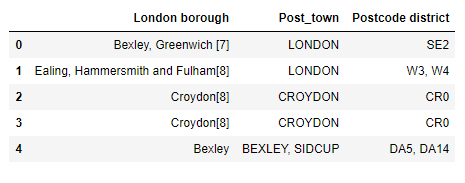

let's rename the Postcode district column and the london borough to something simpler

```python
df1.columns = ['Neighbourhood','town','post_code']
df1
```

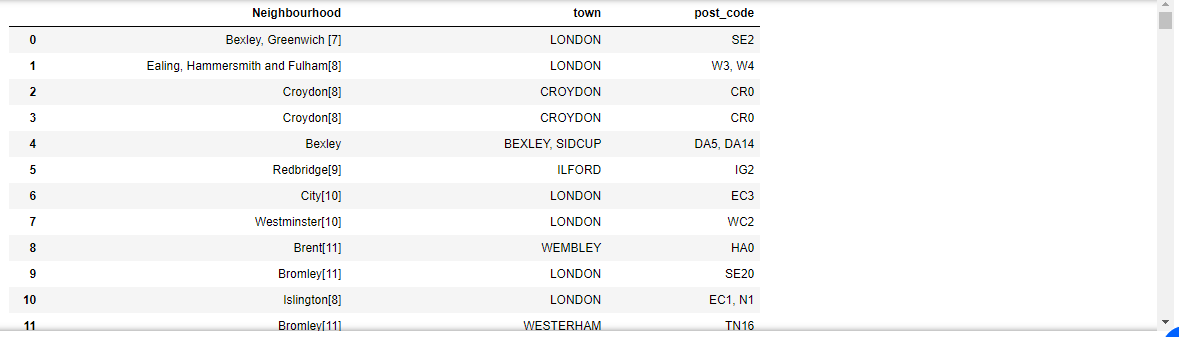

Let's remove the Square brackets [ ] and numbers from the borough column

```python
df1['Neighbourhood'] = df1['Neighbourhood'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df1
```

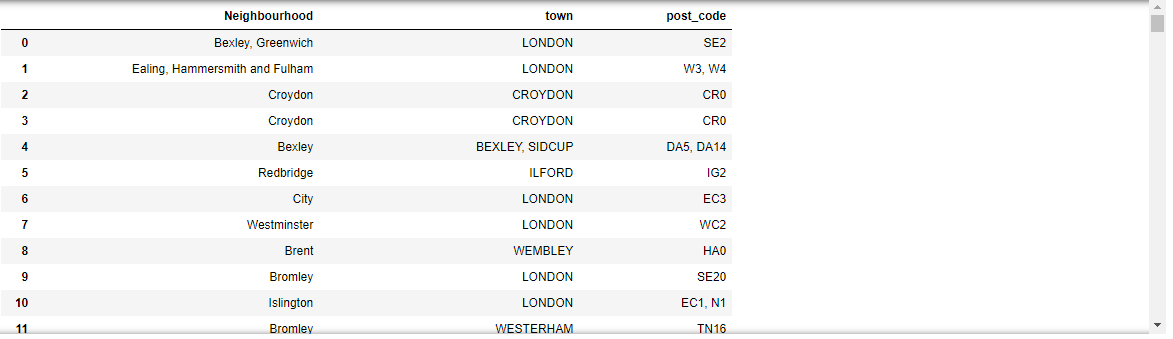

Take the dimension of the dataframe

```python
df1.shape
```

(523,3)

We currently have 523 records and 3 columns of our data. It's time to perform Feature Engineering

#### 4.6 Feature Engineering

We can only focusing on the neighbourhoods of London, so performing the changes

```python
df1 = df1[df1['town'].str.contains('LONDON')]
df1
```

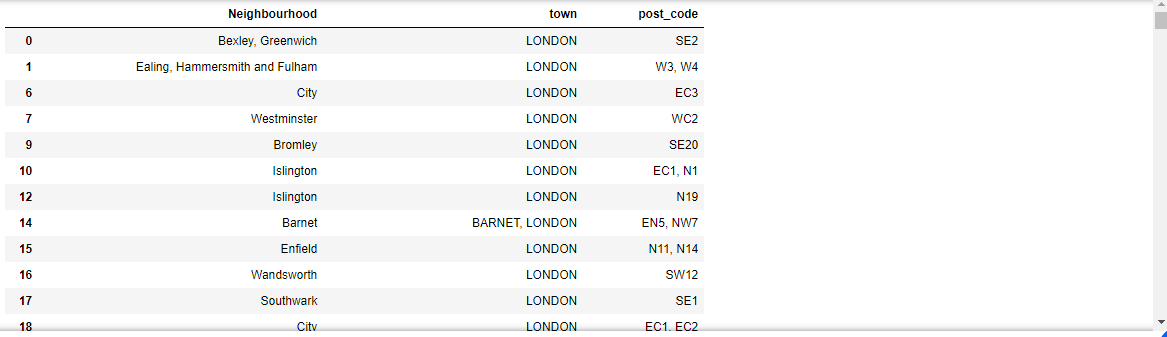

```python
df1.shape
```

(309,3)

We now have only 309 rows. We can proceed with our further steps. Getting some descriptive statistics

```python
df1.info()
```


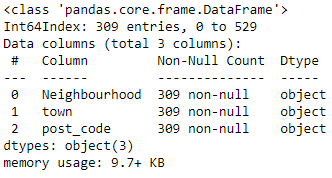

### 4.7. Geolocations of the London Neighbourhoods

#### 4.7.1 ArcGis API

We need to get the geographical co-ordinates for the neighbourhoods to plot out map. We will use the arcgis package to do so. 

```python
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()
```

Defining London arcgis geocode function to return latitude and longitude

```python
def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)
```

Checking sample data

```python
c = get_x_y_uk('SE2')
c
```

'51.492450000000076,0.12127000000003818'

Looks good, We Copy over the postal codes of london to pass it into the geolocator function that we just defined above

```python
geo_coordinates_uk = df1['post_code']    
geo_coordinates_uk
```

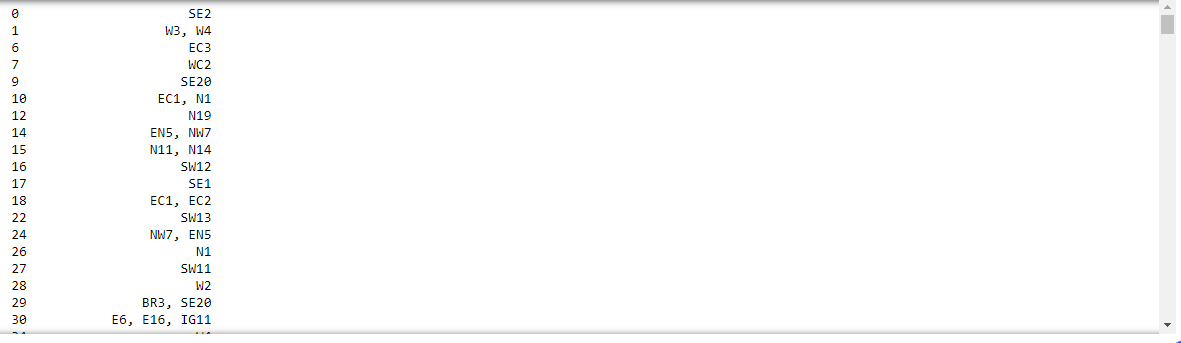

Passing postal codes of london to get the geographical co-ordinates

```python
coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
coordinates_latlng_uk
```

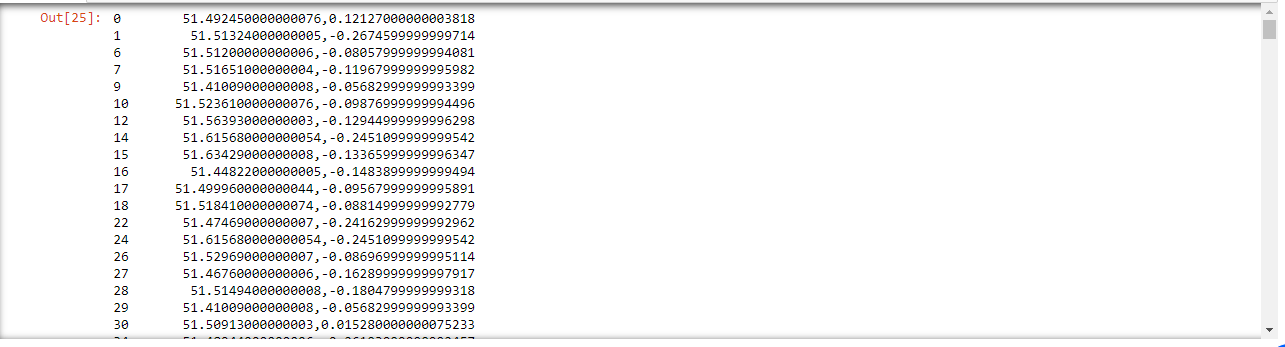

#### Latitude

Extracting the latitude from our previously collected coordinates

```python
lat_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[0])
lat_uk
```

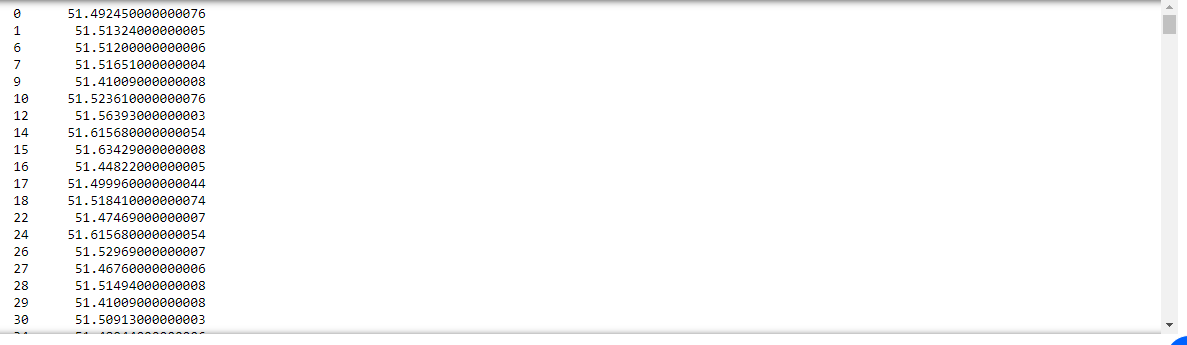

#### Longitude

Extracting the Longitude from our previously collected coordinates

```python
lng_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[1])
lng_uk
```

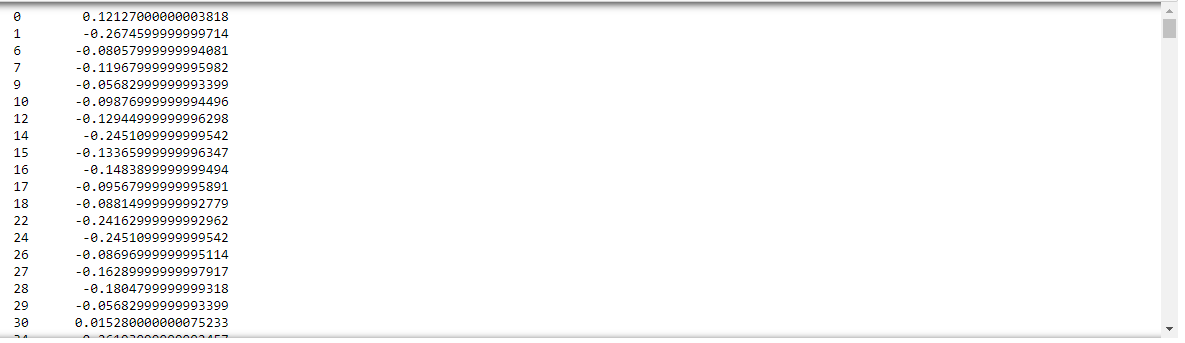

We now have the geographical co-ordinates of the London Neighbourhoods.

We proceed with Merging our source data with the geographical co-ordinates to make our dataset ready for the next stage

```python
london_merged = pd.concat([df1,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['Neighbourhood','town','post_code','latitude','longitude']
london_merged
```

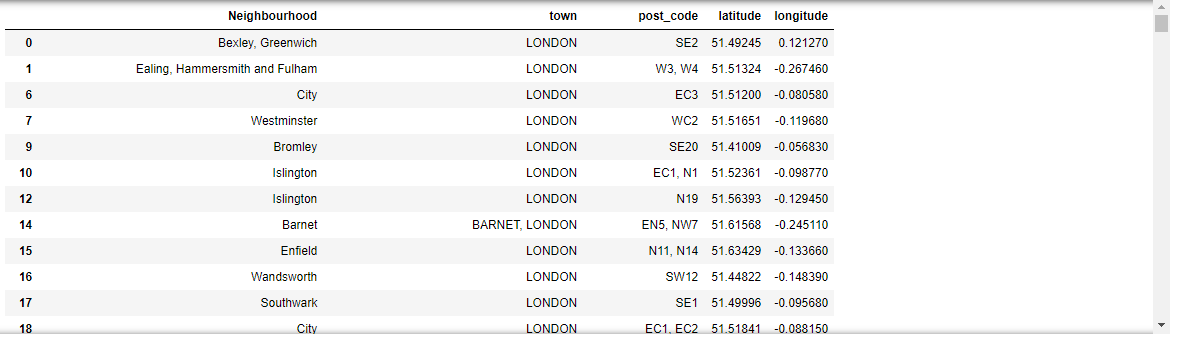

#### 7.7.2. Co-ordinates for London

Getting the geocode for London to help visualize it on the map

```python
london = geocode(address='London, England, GBR')[0]
london_lng_coords = london['location']['x']
london_lat_coords = london['location']['y']
london_lng_coords
```

```python
london_lat_coords
```

#### 4.7.2. Visualize the Map of London

To help visualize the Map of London and the neighbourhoods in London, we make use of the folium package.

```python
# Creating the map of London
map_London = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=12)
map_London

# adding markers to map
for latitude, longitude, Neighbourhood, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['Neighbourhood'], london_merged['town']):
    label = '{}, {}'.format(town, Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_London)  
    
map_London
```

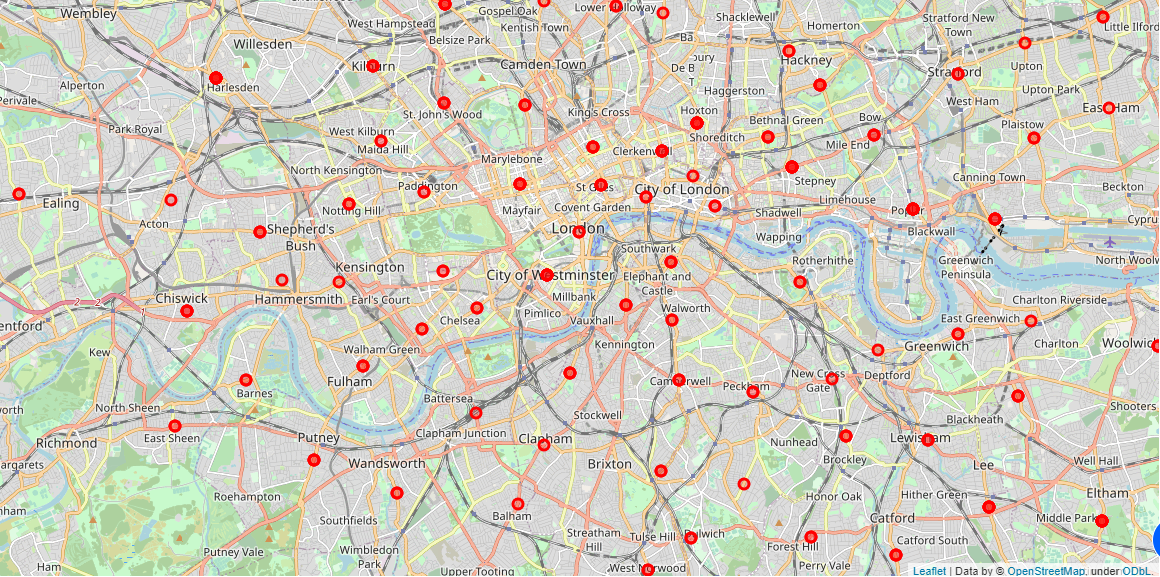

#### 4.8. Venues in London

To proceed with the next part, we need to define Foursquare API credentials.

Using Foursquare API, we are able to get the venue and venue categories around each neighbourhood in London.

```python
CLIENT_ID = '3XW3X3GAEY00VJGDSZXKRT5QWYOPBZFOFPQ1SKL2VBKBVD0G' 
CLIENT_SECRET = 'SLIM5FWPD2TSJD3P2QPV0QYYKX23OJPHHCUXVQRLZVBT2CNH'
VERSION = '20180605' # Foursquare API version
```

Defining a function to get the neraby venues in the neighbourhood. This will help us get venue categories which is important for our analysis

```python
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
```

Getting the venues in London

```python
venues_in_London = getNearbyVenues(names=london_merged['Neighbourhood'], latitudes=london_merged['latitude'], longitudes=london_merged['longitude'])
```

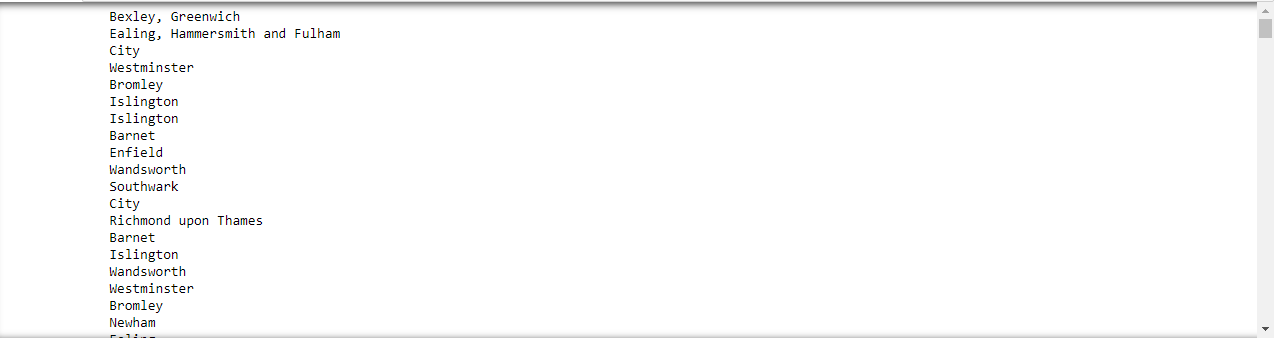

Sampling our data

```python
venues_in_London.head()
```

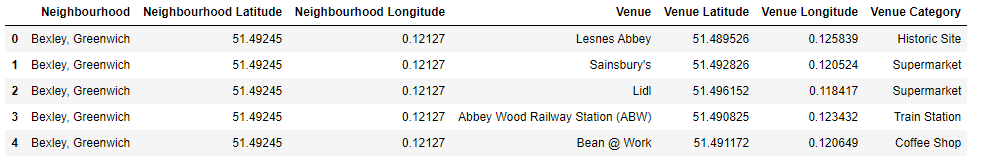

```python
venues_in_London.shape
```

Wow, we have scraped together 10521 records for venues. This will definitely make the clustering interesting.

```python
print('There are {} Uniques Categories.'.format(len(venues_in_London['Venue Category'].unique())))
venues_in_London.groupby('Neighbourhood').count().head()
```

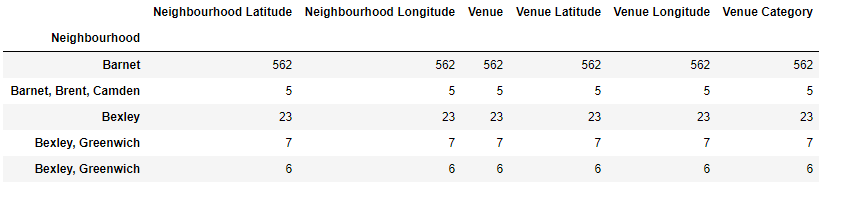

#### 4.8.1 Grouping by Venue Categories
We need to now see how many Venue Categories are there for further processing

```python
venues_in_London.groupby('Venue Category').max()
```

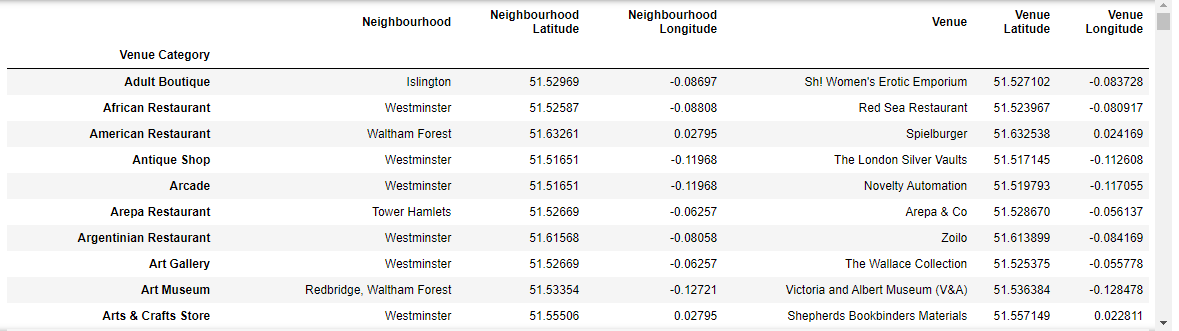

We can see 292 records, just goes to show how diverse and interesting the place is.

#### 4.8.2. One Hot Encoding 
We need to Encode our venue categories to get a better result for our clustering

```python
# one hot encoding
London_onehot = pd.get_dummies(venues_in_London[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighbourhood'] = venues_in_London['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]
London_grouped = London_onehot.groupby('Neighbourhood').mean().reset_index()
London_onehot.head(5)
```

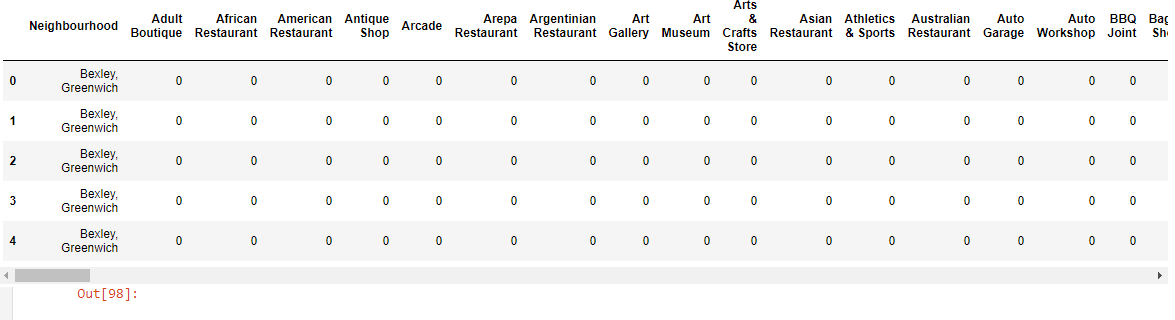

Grouping of each Neighbourhoods with 10 common venues:

```python
num_top_venues = 5
for hood in London_grouped['Neighbourhood']:
    print("---- "+hood+" ----")
    temp =London_grouped[London_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
```

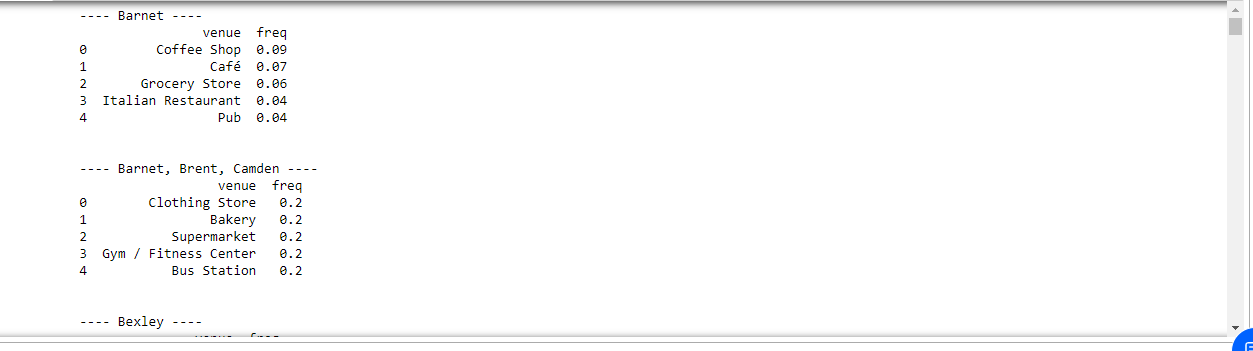

Creating new dataframe — Putting the common venues into pandas dataframe, the following return_most_common_venuesis used to sort the venues in descending order.


```python
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
```

Then we create a new panda dataframe with 10 most common venues

```python
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = London_grouped['Neighbourhood']

for ind in np.arange(London_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()
```

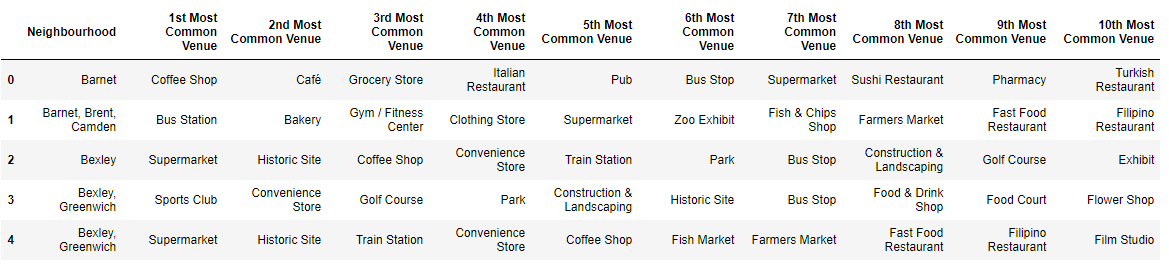

#### 4.9. Model Building

#### K Means
Let's cluster the city of london to roughly 5 to make it easier to analyze. 

We use the K Means clustering technique to do so.

```python
# set number of clusters
k_num_clusters = 5

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
kmeans_london
```

#### Labelling Clustered Data

```python
kmeans_london.labels_[0:10]
```

```python
# Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
London_merged = London_grouped.copy()
# Add the clustering labels
London_merged["Cluster Labels"] = kmeans_london.labels_
London_merged.rename(columns={"borough": "Neighbourhood"}, inplace=True)
London_merged.head(10)
```

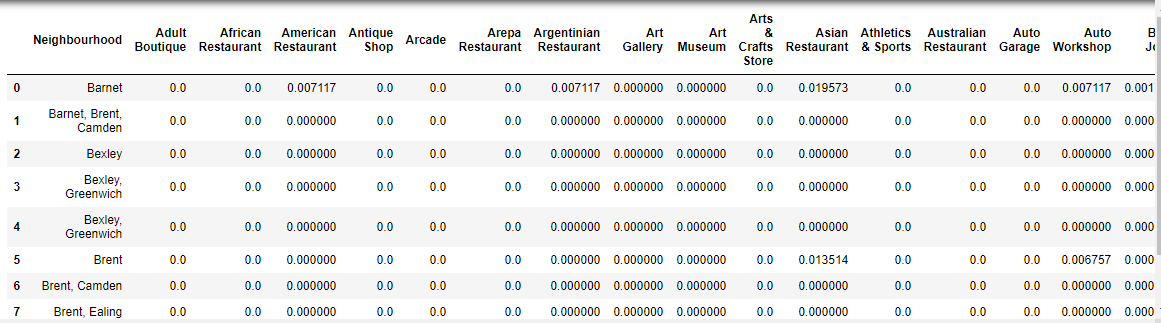

```python
London_merged['Latitude'] = venues_in_London['Neighbourhood Latitude']
London_merged['Longitude'] = venues_in_London['Neighbourhood Longitude']
# Sorting the results by Cluster Labels
London_merged.sort_values(["Cluster Labels"], inplace=True)
London_merged
```

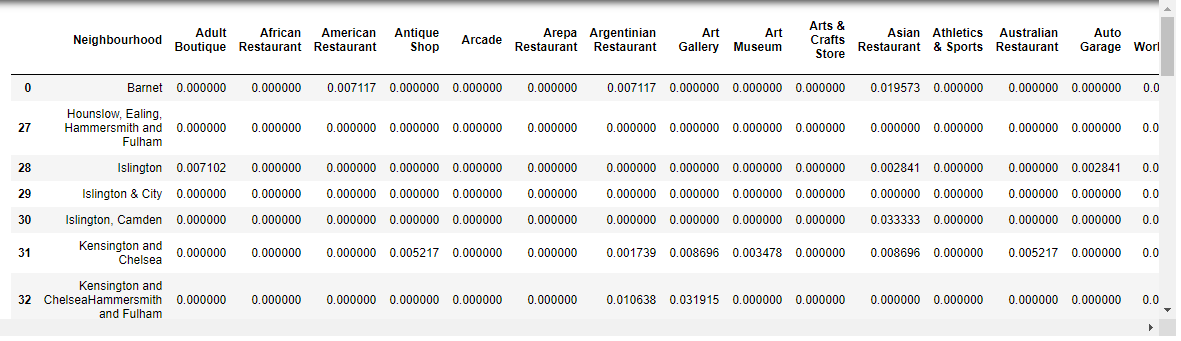

Drop all the NaN values to prevent data skew

```python
London_merged_nonan = London_merged.dropna(subset=['Cluster Labels'])
```

#### 4.9.1 Visualizing the clustered neighbourhood
Let's plot the clusters

```python
map_clusters_london = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged_nonan['Latitude'], London_merged_nonan['Longitude'], London_merged_nonan['Neighbourhood'], London_merged_nonan['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(map_clusters_london)
        
map_clusters_london
```

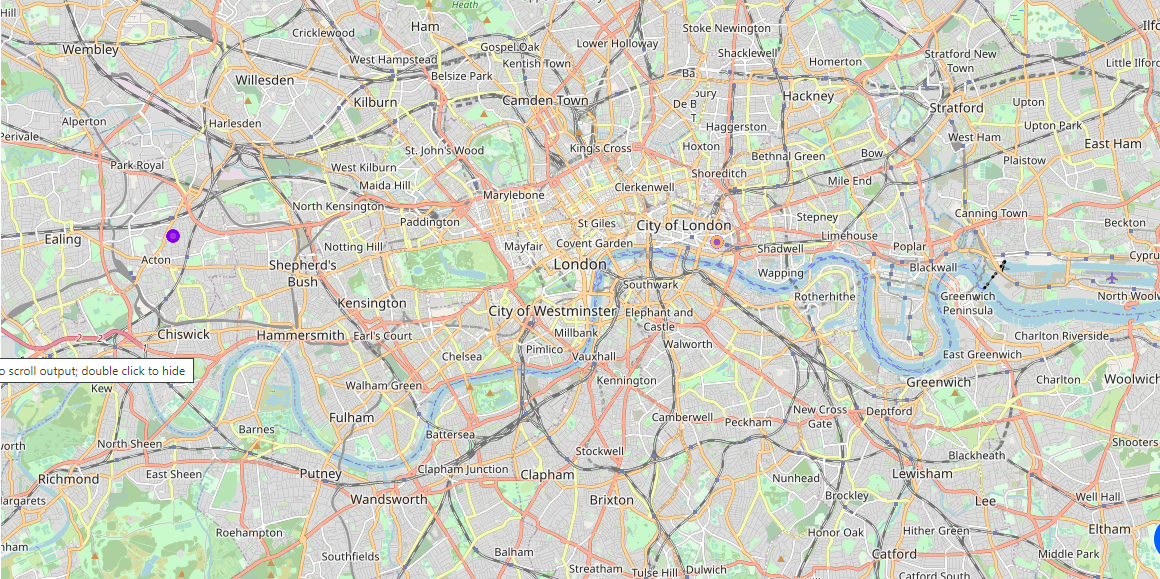

Plot another cluster

```python
# create map
map_clusters = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged_nonan['Latitude'], London_merged_nonan['Longitude'], London_merged_nonan['Neighbourhood'], London_merged_nonan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
display(map_clusters)
```

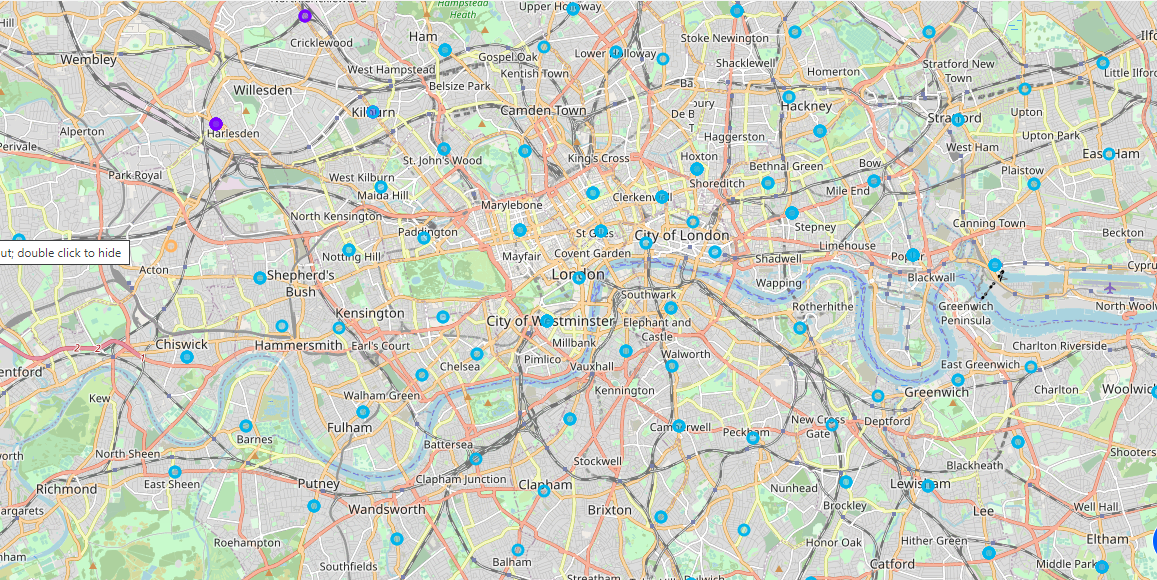

#### 4.9.2. Examining our Clusters

```python
London_merged_nonan.loc[London_merged_nonan['Cluster Labels'] == 1, London_merged_nonan.columns[[1] + list(range(5, London_merged_nonan.shape[1]))]]
```

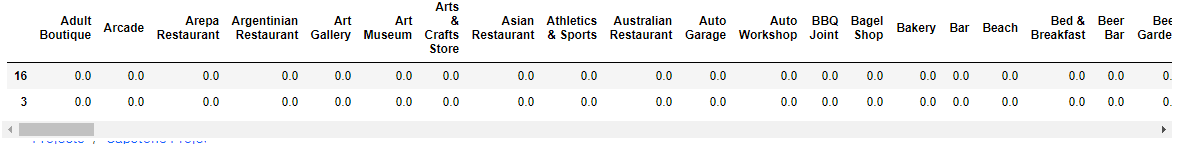

Cluster 2

```python
London_merged_nonan.loc[London_merged_nonan['Cluster Labels'] == 2, London_merged_nonan.columns[[1] + list(range(5, London_merged_nonan.shape[1]))]]
```

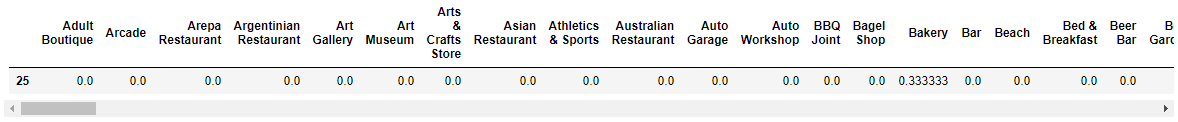

Cluster 3

```python
London_merged_nonan.loc[London_merged_nonan['Cluster Labels'] == 3, London_merged_nonan.columns[[1] + list(range(5, London_merged_nonan.shape[1]))]]
```

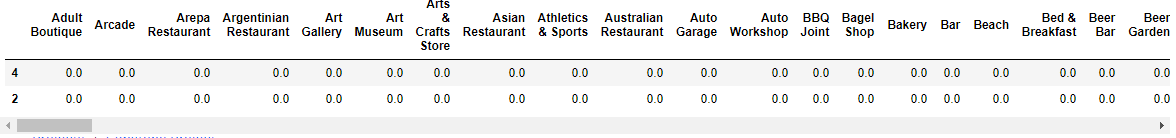

Cluster 4

```python
London_merged_nonan.loc[London_merged_nonan['Cluster Labels'] == 4, London_merged_nonan.columns[[1] + list(range(5, London_merged_nonan.shape[1]))]]
```

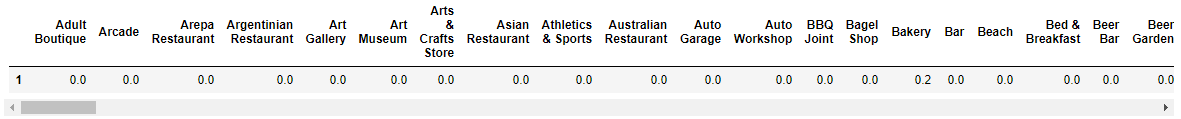

Cluster 5

```python
London_merged_nonan.loc[London_merged_nonan['Cluster Labels'] == 5, London_merged_nonan.columns[[1] + list(range(5, London_merged_nonan.shape[1]))]]
```

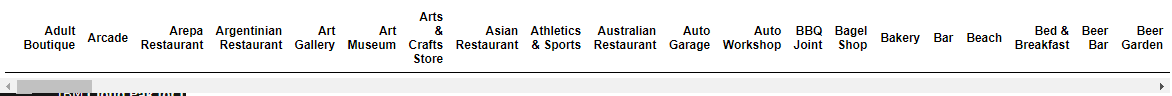

### 5. Results and Discussion

The neighbourhoods of London are very mulitcultural. There are a lot of different cusines including Indian, Italian, Turkish and Chinese. London seems to take a step further in this direction by having a lot of Restaurants, bars, juice bars, coffee shops, Fish and Chips shop and Breakfast spots. It has a lot of shopping options too with that of the Flea markets, flower shops, fish markets, Fishing stores, clothing stores. The main modes of transport seem to be Buses and trains. For leisure, the neighbourhoods are set up to have lots of parks, golf courses, zoo, gyms and Historic sites.

Overall, the city of London offers a multicultural, diverse and certainly an entertaining experience.

### 6. Conclusion

The purpose of this project was to explore the city of London and see how attractive it is to potential tourists and migrants. We explored the city based on their postal codes and then extrapolated the common venues present in each of the neighbourhoods finally concluding with clustering similar neighbourhoods together.

We could see that each of the neighbourhoods in the city of London has a wide variety of experiences to offer which is unique in it's own way. The cultural diversity is quite evident which also gives the feeling of a sense of inclusion.

London seems to offer a vacation stay or a romantic gateaway with a lot of places to explore, beautiful landscapes and a wide variety of culture.Overall.

The detailed code is available on [GitHub](https://github.com/khaldoun-s/Coursera_Capstone/blob/main/London%20Destinations%20Chooser/London%20Destinations%20Chooser.ipynb)

### 6. Conclusion

1.   [Capstone Project — The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto
](https://medium.com/@sumitsinghchaudhary98/capstone-project-the-battle-of-neighborhoods-finding-a-better-place-in-scarborough-toronto-6aad0df1ba6e)

2.   [The Battle of Neighbourhood — My London’s Perspective](https://medium.com/@oludayo.oguntoyinbo/the-battle-of-neighbourhood-my-londons-perspective-d363163771e0)

3. [Foursquare API](https://foursquare.com)

4. [ArcGIS API](https://www.arcgis.com/index.html)

